<a href="https://colab.research.google.com/github/simahashemi/Quasi_Experimental_methods/blob/main/Quasi_Experimental_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from linearmodels.iv import IV2SLS

# 1. Difference-in-Differences(DiD)
In this method, we aim to measure the effect of introducing a specific treatment for a particular disease. In our example, some hospitals adopted the treatment (treatment group), while others did not (control group). We assume we have data on the number of cured patients in both groups, collected from last year (before the treatment was introduced) and this year (after the treatment was implemented).

## Generate an artificial dataset

In [99]:
np.random.seed(42)

n = 100

# Define groups and time
group = np.repeat([0, 1], n//2)  # 0 = control, 1 = treatment
time = np.tile([0, 1], n//2)     # 0 = before, 1 = after

# Simulate outcome
baseline = 50
treatment_effect = 5

# Add actual effect for treated group after time
outcome = baseline \
          + 2*time \
          + (-1)*group \
          + treatment_effect*(group*time) \
          + np.random.normal(0, 2, n)

# Create DataFrame
df = pd.DataFrame({
    'outcome': outcome,
    'group': group,
    'time': time
})

df.head()

,outcome,group,time
0,50.993428,0,0
1,51.723471,0,1
2,51.295377,0,0
3,55.046060,0,1
4,49.531693,0,0


## Apply DiD on data


In [100]:
df['interaction'] = df['time'] * df['group']
df.head()

# DiD Regression model
DiD_model = ols('outcome ~ time + group + interaction',data = df).fit()

print(DiD_model.summary())


                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     83.69
Date:                Mon, 26 May 2025   Prob (F-statistic):           1.09e-26
Time:                        19:25:09   Log-Likelihood:                -199.72
No. Observations:                 100   AIC:                             407.4
Df Residuals:                      96   BIC:                             417.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      49.6404      0.364    136.398      

The R-squared value is approximately 0.72, indicating that the model explains a substantial portion of the variation in the outcome. The interaction coefficient is 5.6, suggesting that the treatment has a strong positive effect on the outcome.

## Plotting the Results

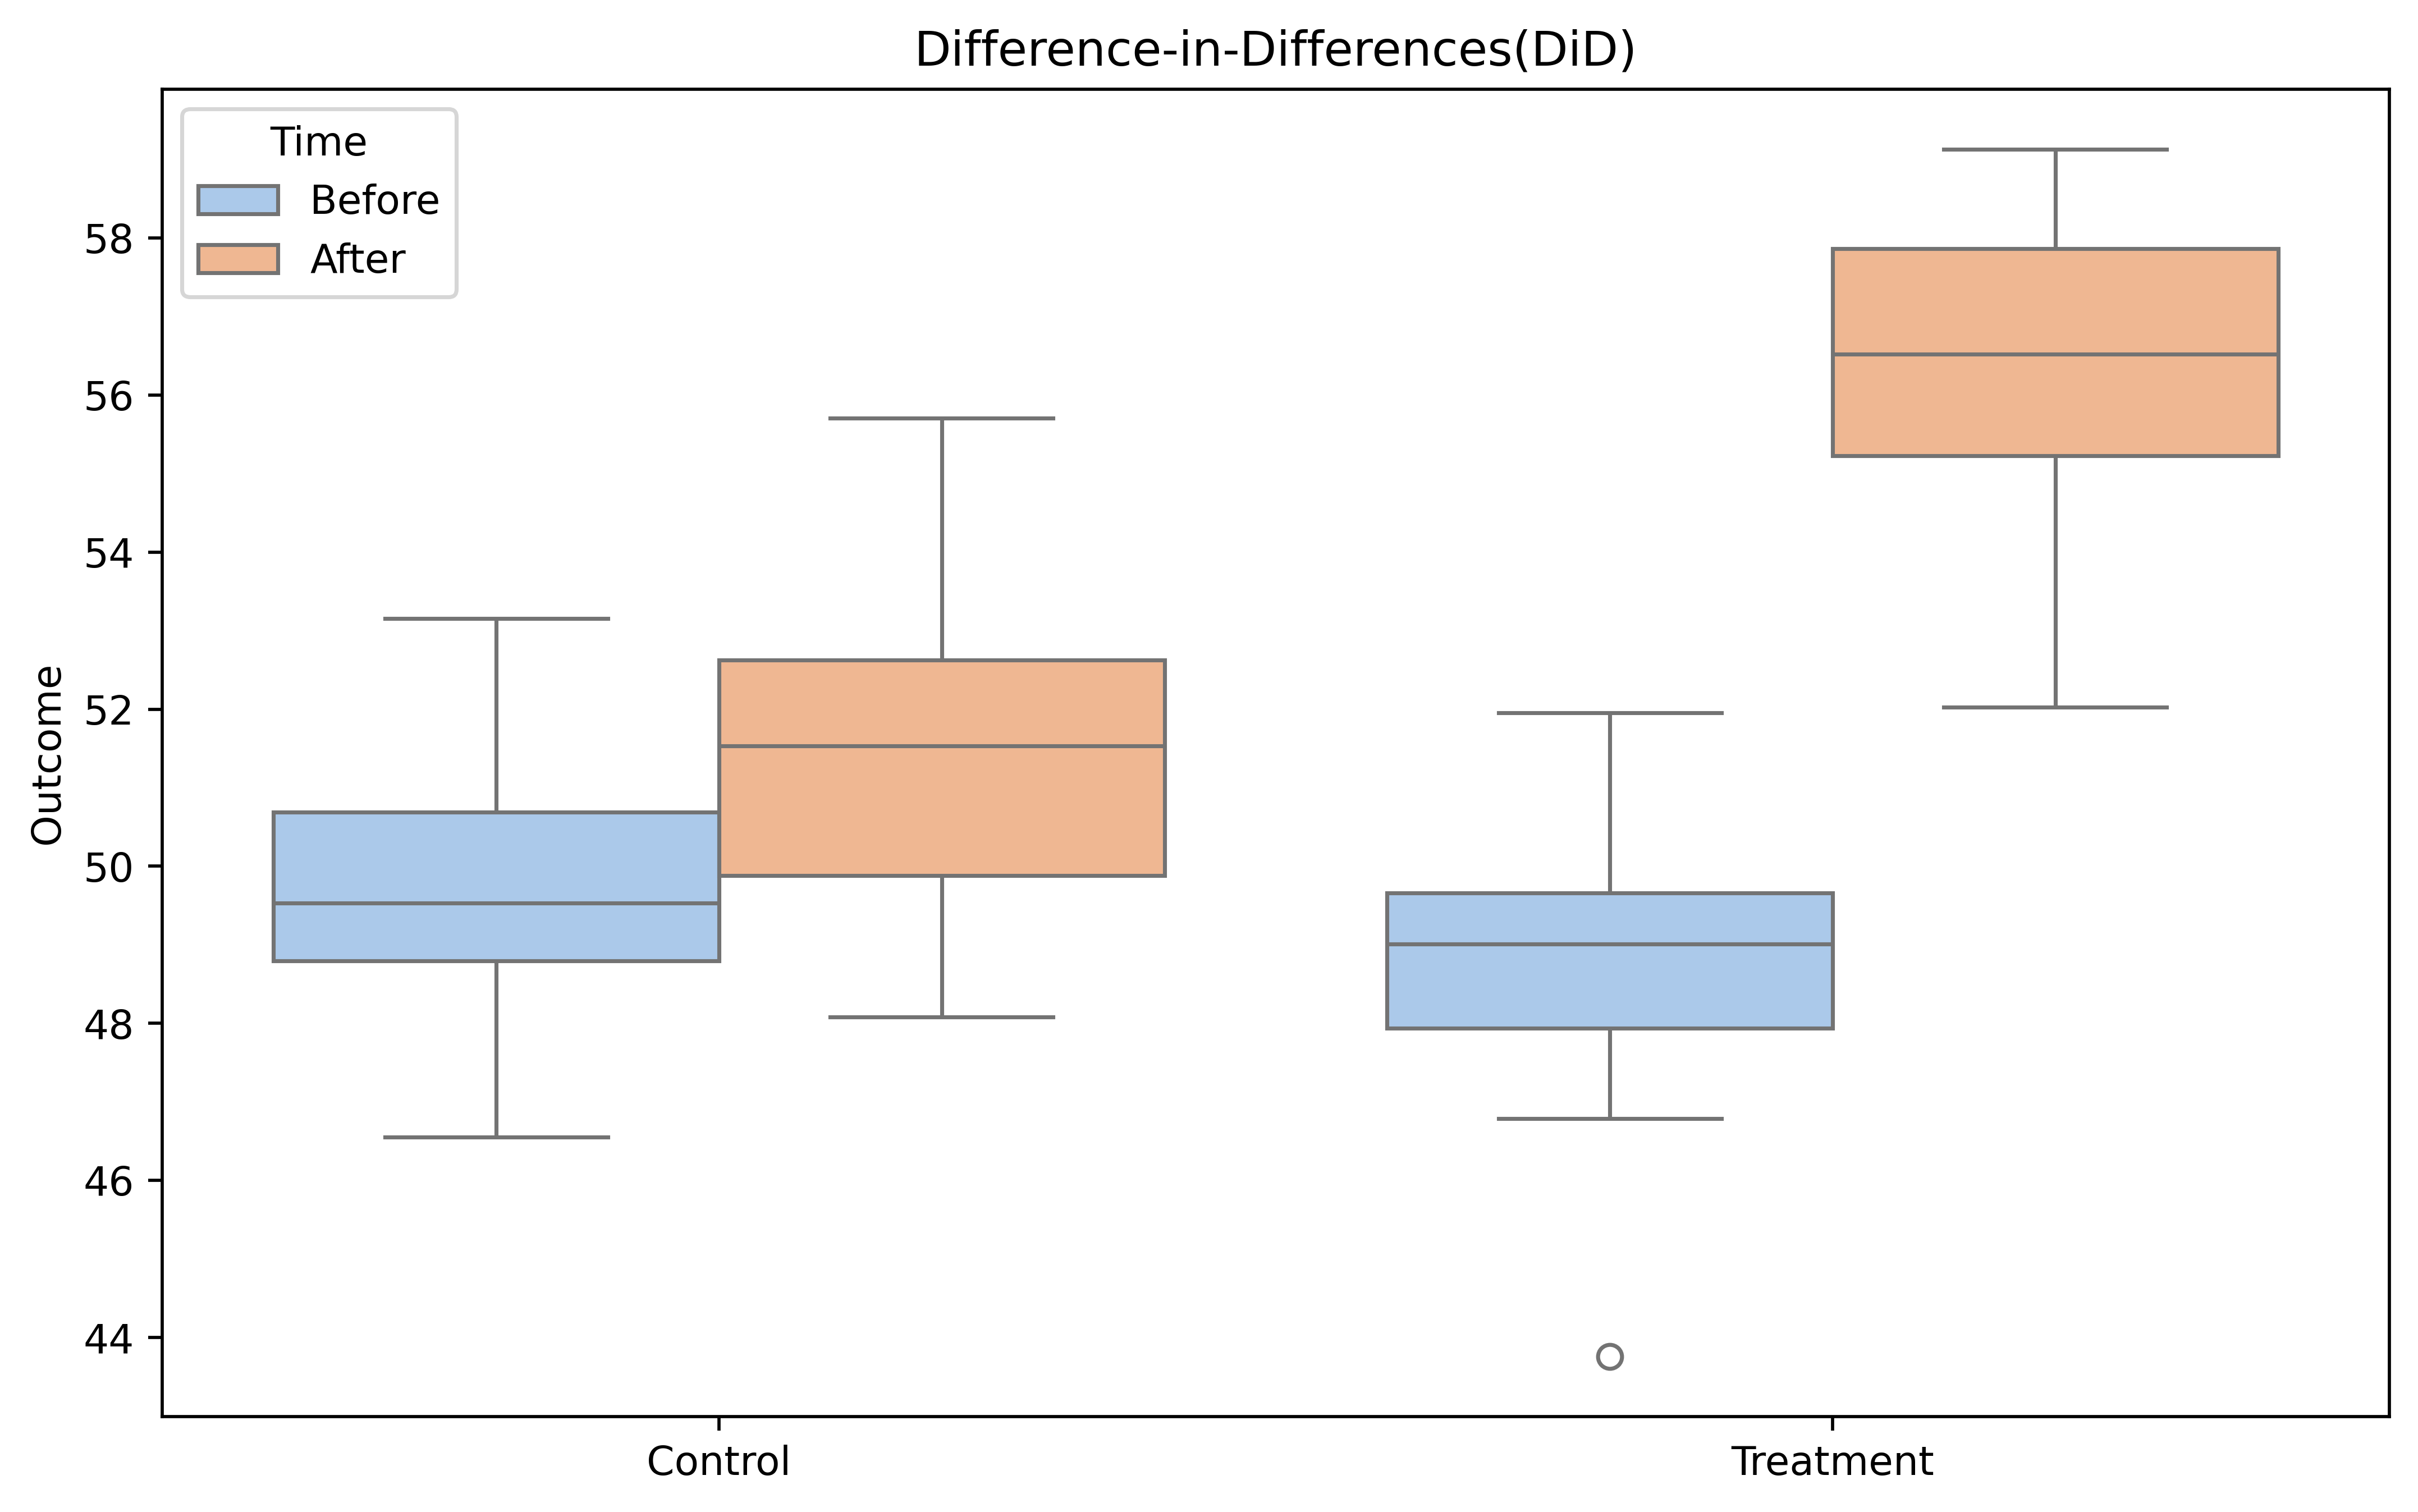

In [101]:
plt.figure(figsize=(10,6),dpi=512)
sns.boxplot(x = 'group',y = 'outcome',data = df,hue = 'time', palette='pastel',hue_order=[0, 1])
plt.xlabel('')
plt.ylabel('Outcome')
plt.title('Difference-in-Differences(DiD)')
plt.xticks([0,1],['Control','Treatment'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Before', 'After'], title='Time')
plt.show()

This plot illustrates the before-and-after stages for both groups. In the control group, the number of cured patients increased only slightly, whereas the treatment group shows a significant increase, indicating a positive effect of the treatment.

# 2. Propensity Score Matching (PSM)
This method aims to identify comparable cases from the treatment and control groups based on a predefined propensity score. These matched pairs are then used to assess the effect of the treatment.



## Generate an artificial dataset


In [104]:
np.random.seed(42)
n = 200
age = np.random.normal(60, 10, n).astype(int)
gender = np.random.choice([0, 1], n)  # 0: female, 1: male
treatment = (age + gender * 5 + np.random.normal(0, 5, n)) > 65  # higher treatment probability for older people
treatment = treatment.astype(int)
outcome = 120 - 5 * treatment + age * 0.1 + gender * 2 + np.random.normal(0, 3, n)

df = pd.DataFrame({
    'age': age,
    'gender': gender,
    'treatment': treatment,
    'outcome': outcome
})
df.head()

,age,gender,treatment,outcome
0,64,1,1,121.460281
1,58,1,1,119.555356
2,66,0,1,126.661425
3,75,1,1,127.144919
4,57,0,0,125.676082


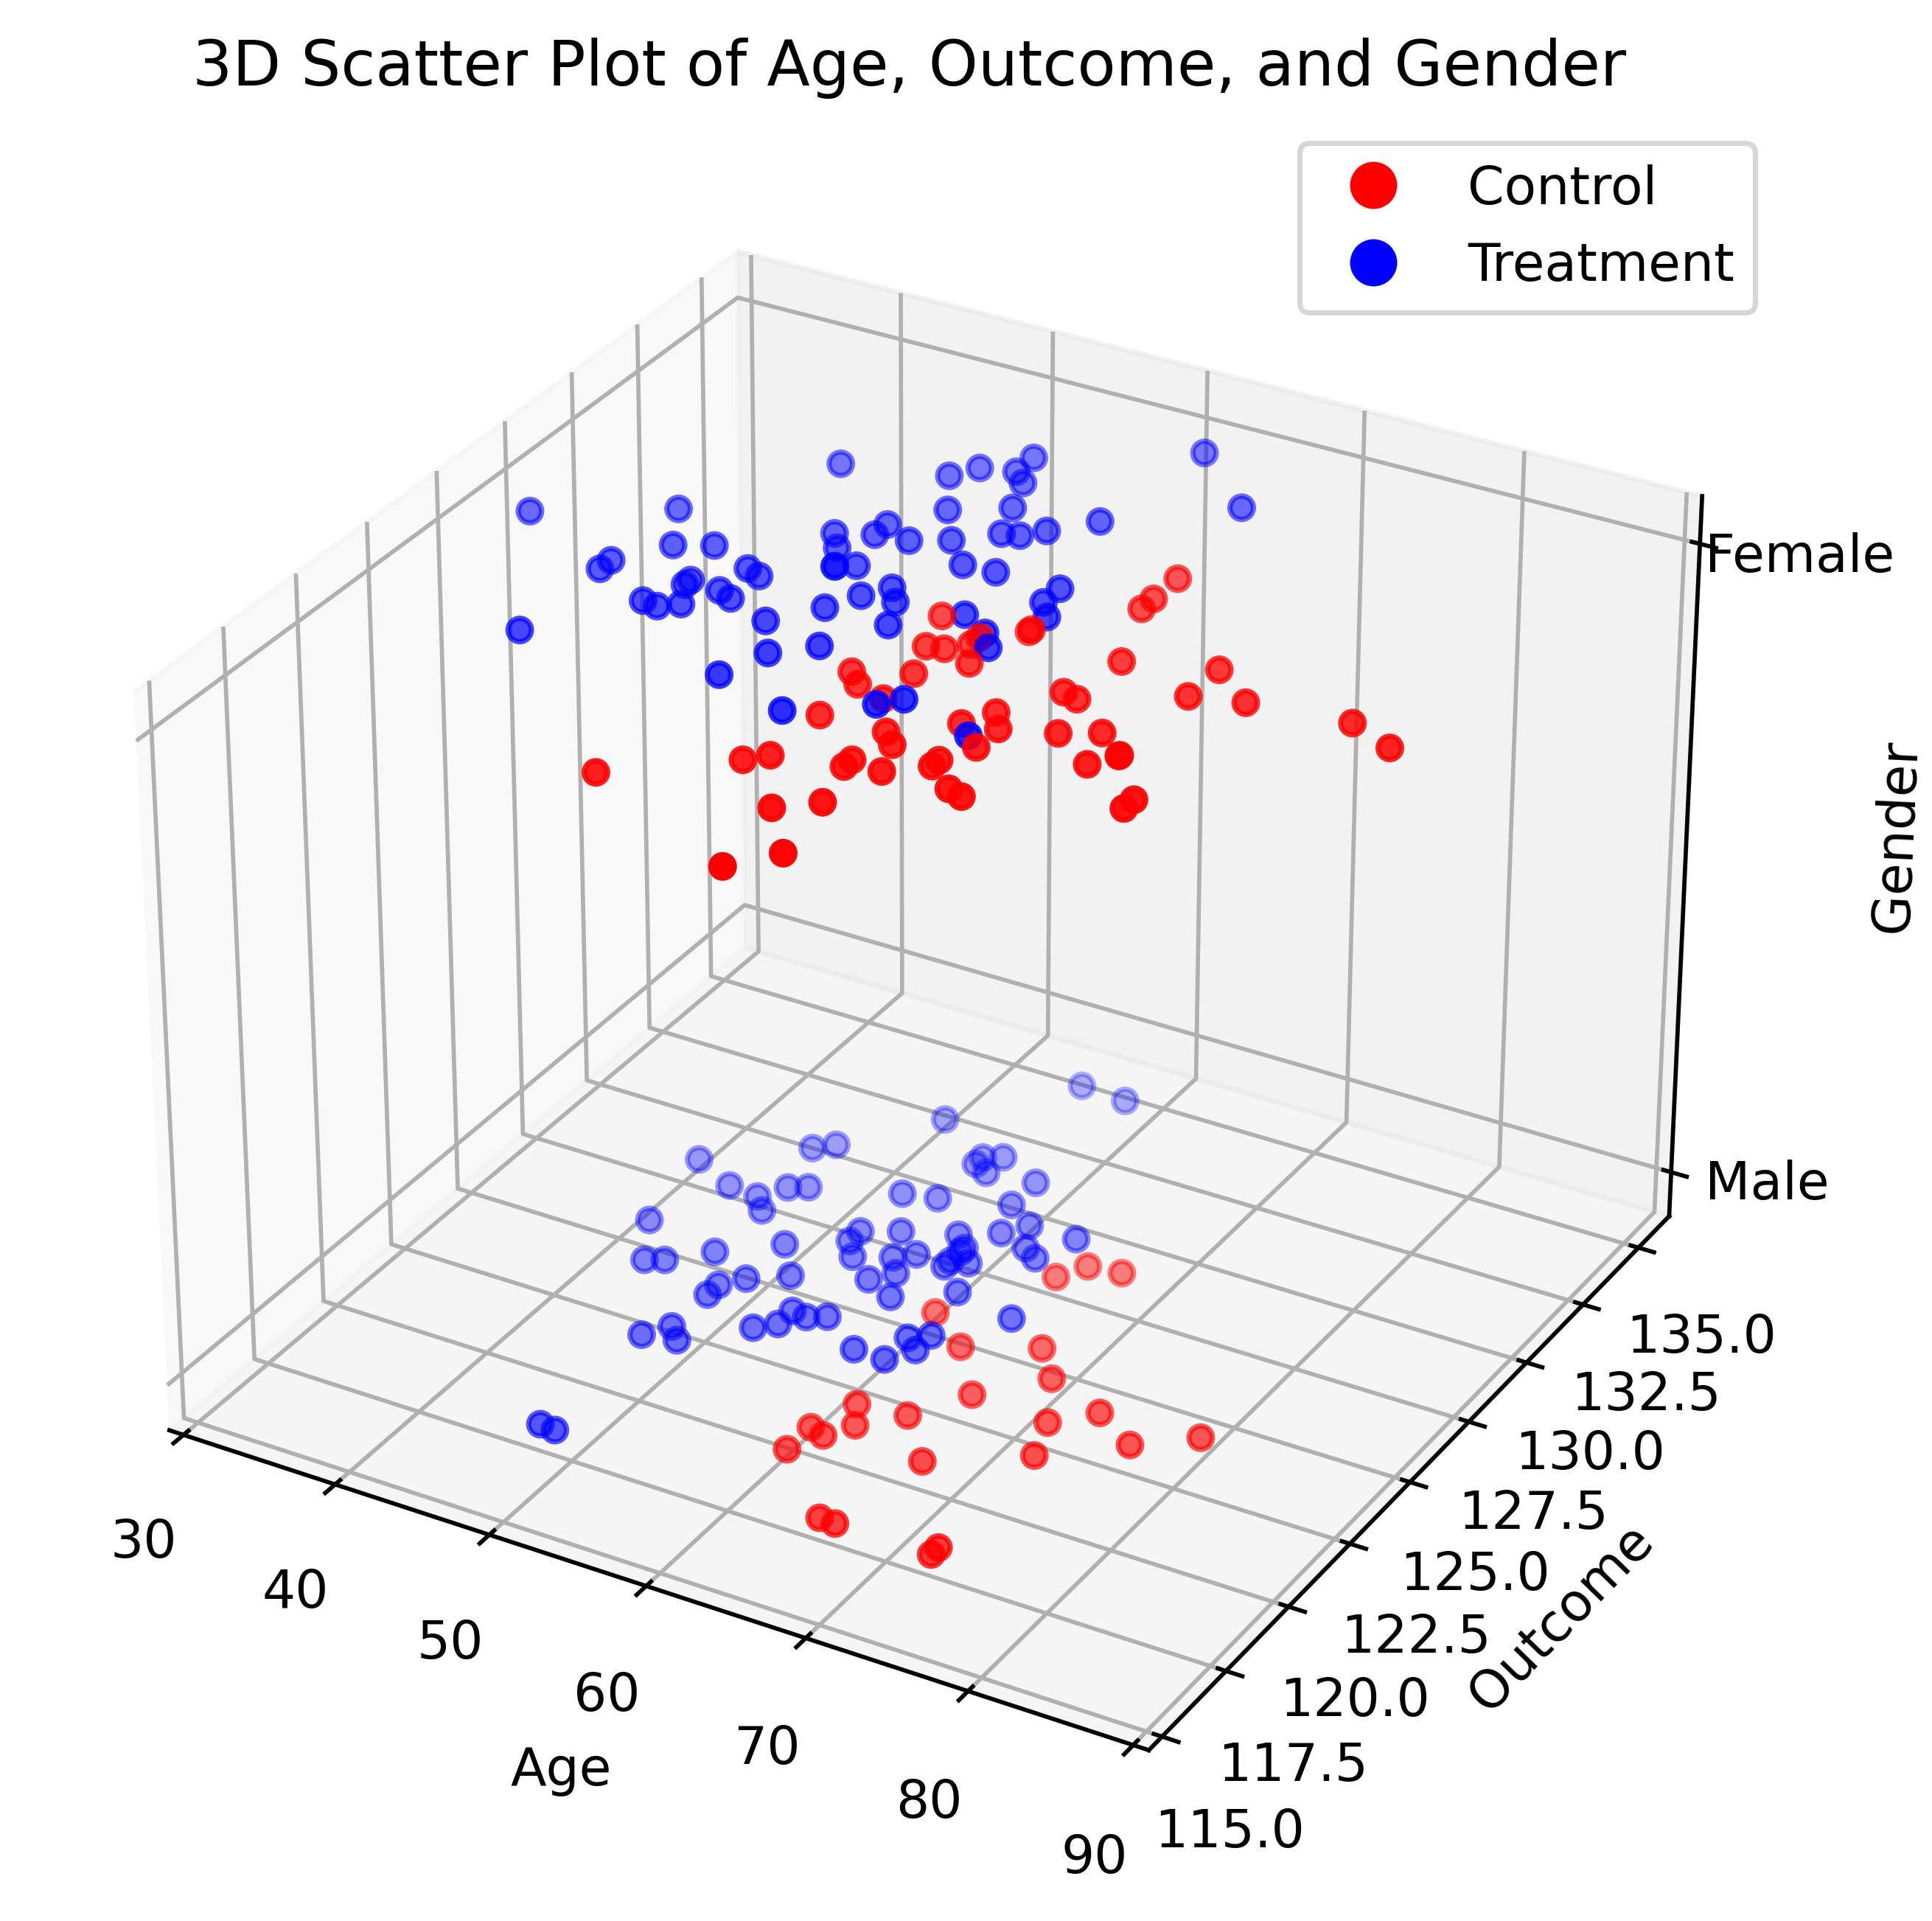

In [105]:
fig = plt.figure(figsize=(10,6),dpi=512)
ax = fig.add_subplot(111, projection='3d')
colors = df['treatment'].map({0: 'blue', 1: 'red'})
ax.scatter(df['age'], df['outcome'],df['gender'], c=colors)
ax.set_xlabel('Age')
ax.set_zlabel('Gender')
ax.set_ylabel('Outcome')
ax.set_zticks([0,1],['Male','Female'])
plt.title('3D Scatter Plot of Age, Outcome, and Gender')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.unique()]
plt.legend(handles,['Control', 'Treatment'])
plt.show()

## Apply PSM on data

In [106]:
# calculating the propencity score
from sklearn.linear_model import LogisticRegression

X = df[['age', 'gender']]
Y = df['treatment']

lm = LogisticRegression()
lm.fit(X, Y)
propensity_score = lm.predict_proba(X)[:,1]

df['propensity_score'] = propensity_score
df.head()

,age,gender,treatment,outcome,propensity_score
0,64,1,1,121.460281,0.784975
1,58,1,1,119.555356,0.230496
2,66,0,1,126.661425,0.705835
3,75,1,1,127.144919,0.997210
4,57,0,0,125.676082,0.053384


In [107]:
# match propensity score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
treat_group = df[df['treatment'] == 1]
control_group = df[df['treatment'] == 0]
treat_score_scaled = scaler.fit_transform(treat_group['propensity_score'].values.reshape(-1, 1))
control_score_scaled = scaler.transform(control_group['propensity_score'].values.reshape(-1, 1))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_score_scaled)
distances, indices = nn.kneighbors(treat_score_scaled)

In [108]:
len(control_score_scaled)

125

In [109]:
treat_group['match'] = indices.flatten()
treat_group['match_outcome'] = control_group.iloc[indices.flatten()]['outcome'].values
treat_group.head()

<ipython-input-109-51dda37aaca8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_group['match'] = indices.flatten()
<ipython-input-109-51dda37aaca8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_group['match_outcome'] = control_group.iloc[indices.flatten()]['outcome'].values


,age,gender,treatment,outcome,propensity_score,match,match_outcome
0,64,1,1,121.460281,0.784975,115,127.371937
1,58,1,1,119.555356,0.230496,71,130.070966
2,66,0,1,126.661425,0.705835,35,124.869324
3,75,1,1,127.144919,0.997210,114,122.479829
6,75,0,1,122.732105,0.990300,114,122.479829


## Plotting the Results

-2.1143091938678853


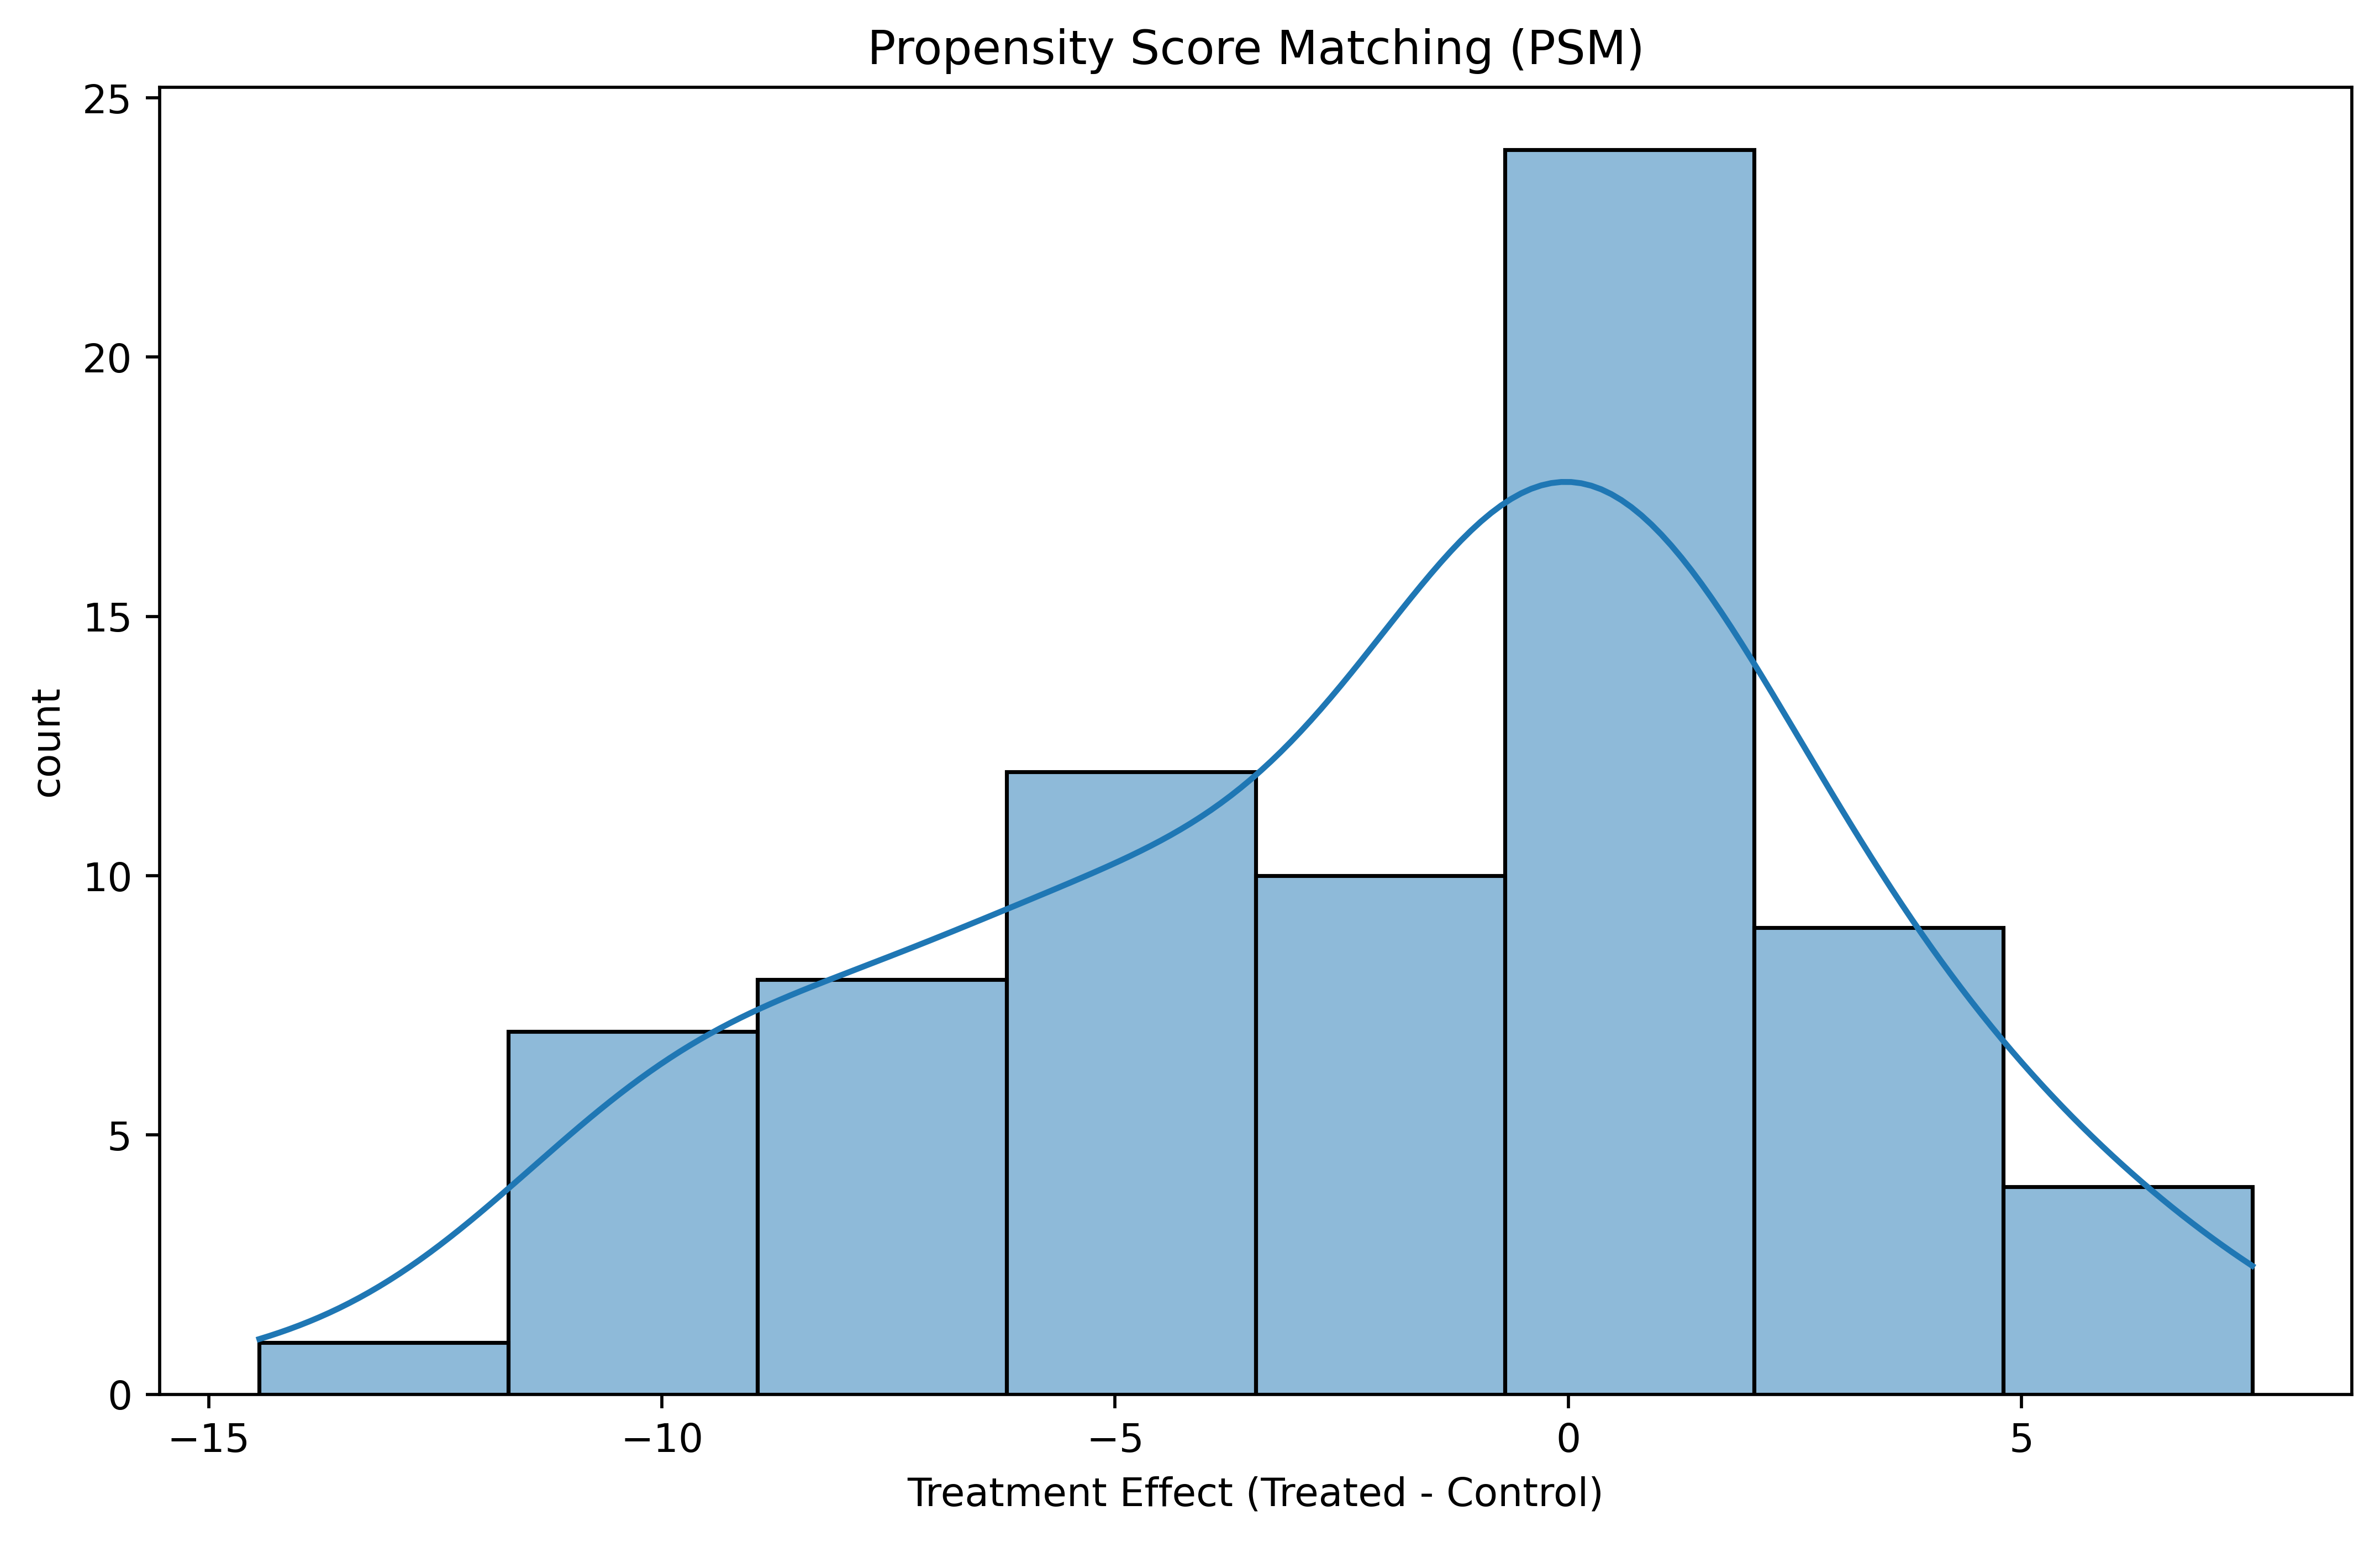

In [111]:
## compare the outcome between matched cases
treatment_effect = treat_group['outcome']-treat_group['match_outcome']
print(np.mean(treatment_effect))
plt.figure(figsize=(10,6),dpi=512)
sns.histplot(treatment_effect, kde=True)
plt.ylabel('count')
plt.title("Propensity Score Matching (PSM)")
plt.xlabel("Treatment Effect (Treated - Control)")
plt.show()

This plot indicates that the treatment generally leads to lower values of the outcome variable. While this is a synthetic dataset, in real-world scenarios, the interpretation depends on the specific meaning of the outcome. For example, if the outcome represents the number of days spent in the hospital, then a lower value would suggest that the treatment was effective in reducing hospitalization time.

# Interrupted Time Series (ITS)
In this method, we want to measure the effect of a treatment, policy or change on the series of outcome. For this method, we need to have the a time serie of outcome, before and after the change.
model:
$Y_t = β_0 + \beta_1 t_{before} + β_2 * intervention + \beta_3 t_{after} + noise$

## Generate artificial dataset

In [56]:
np.random.seed(42)

# n days
n = 100

time = np.arange(n)

# intervention on day 51
intervention = np.where(time >= 50, 1, 0)

time_after = np.where(time >= 50, time - 50, 0)

baseline_trend = 0.1 * time

level_change = -5 * intervention

trend_change = -0.2 * time_after

noise = np.random.normal(0, 0.5, n)

outcome = 10 + baseline_trend + level_change + trend_change + noise

df = pd.DataFrame({'time': time, 'intervention': intervention, 'time_after': time_after, 'outcome': outcome})


df

,time,intervention,time_after,outcome
0,0,0,0,10.248357
1,1,0,0,10.030868
2,2,0,0,10.523844
3,3,0,0,11.061515
4,4,0,0,10.282923
...,...,...,...,...
95,95,1,45,4.768243
96,96,1,46,5.548060
97,97,1,47,5.430528
98,98,1,48,5.202557


Text(0, 0.5, 'Outcome')

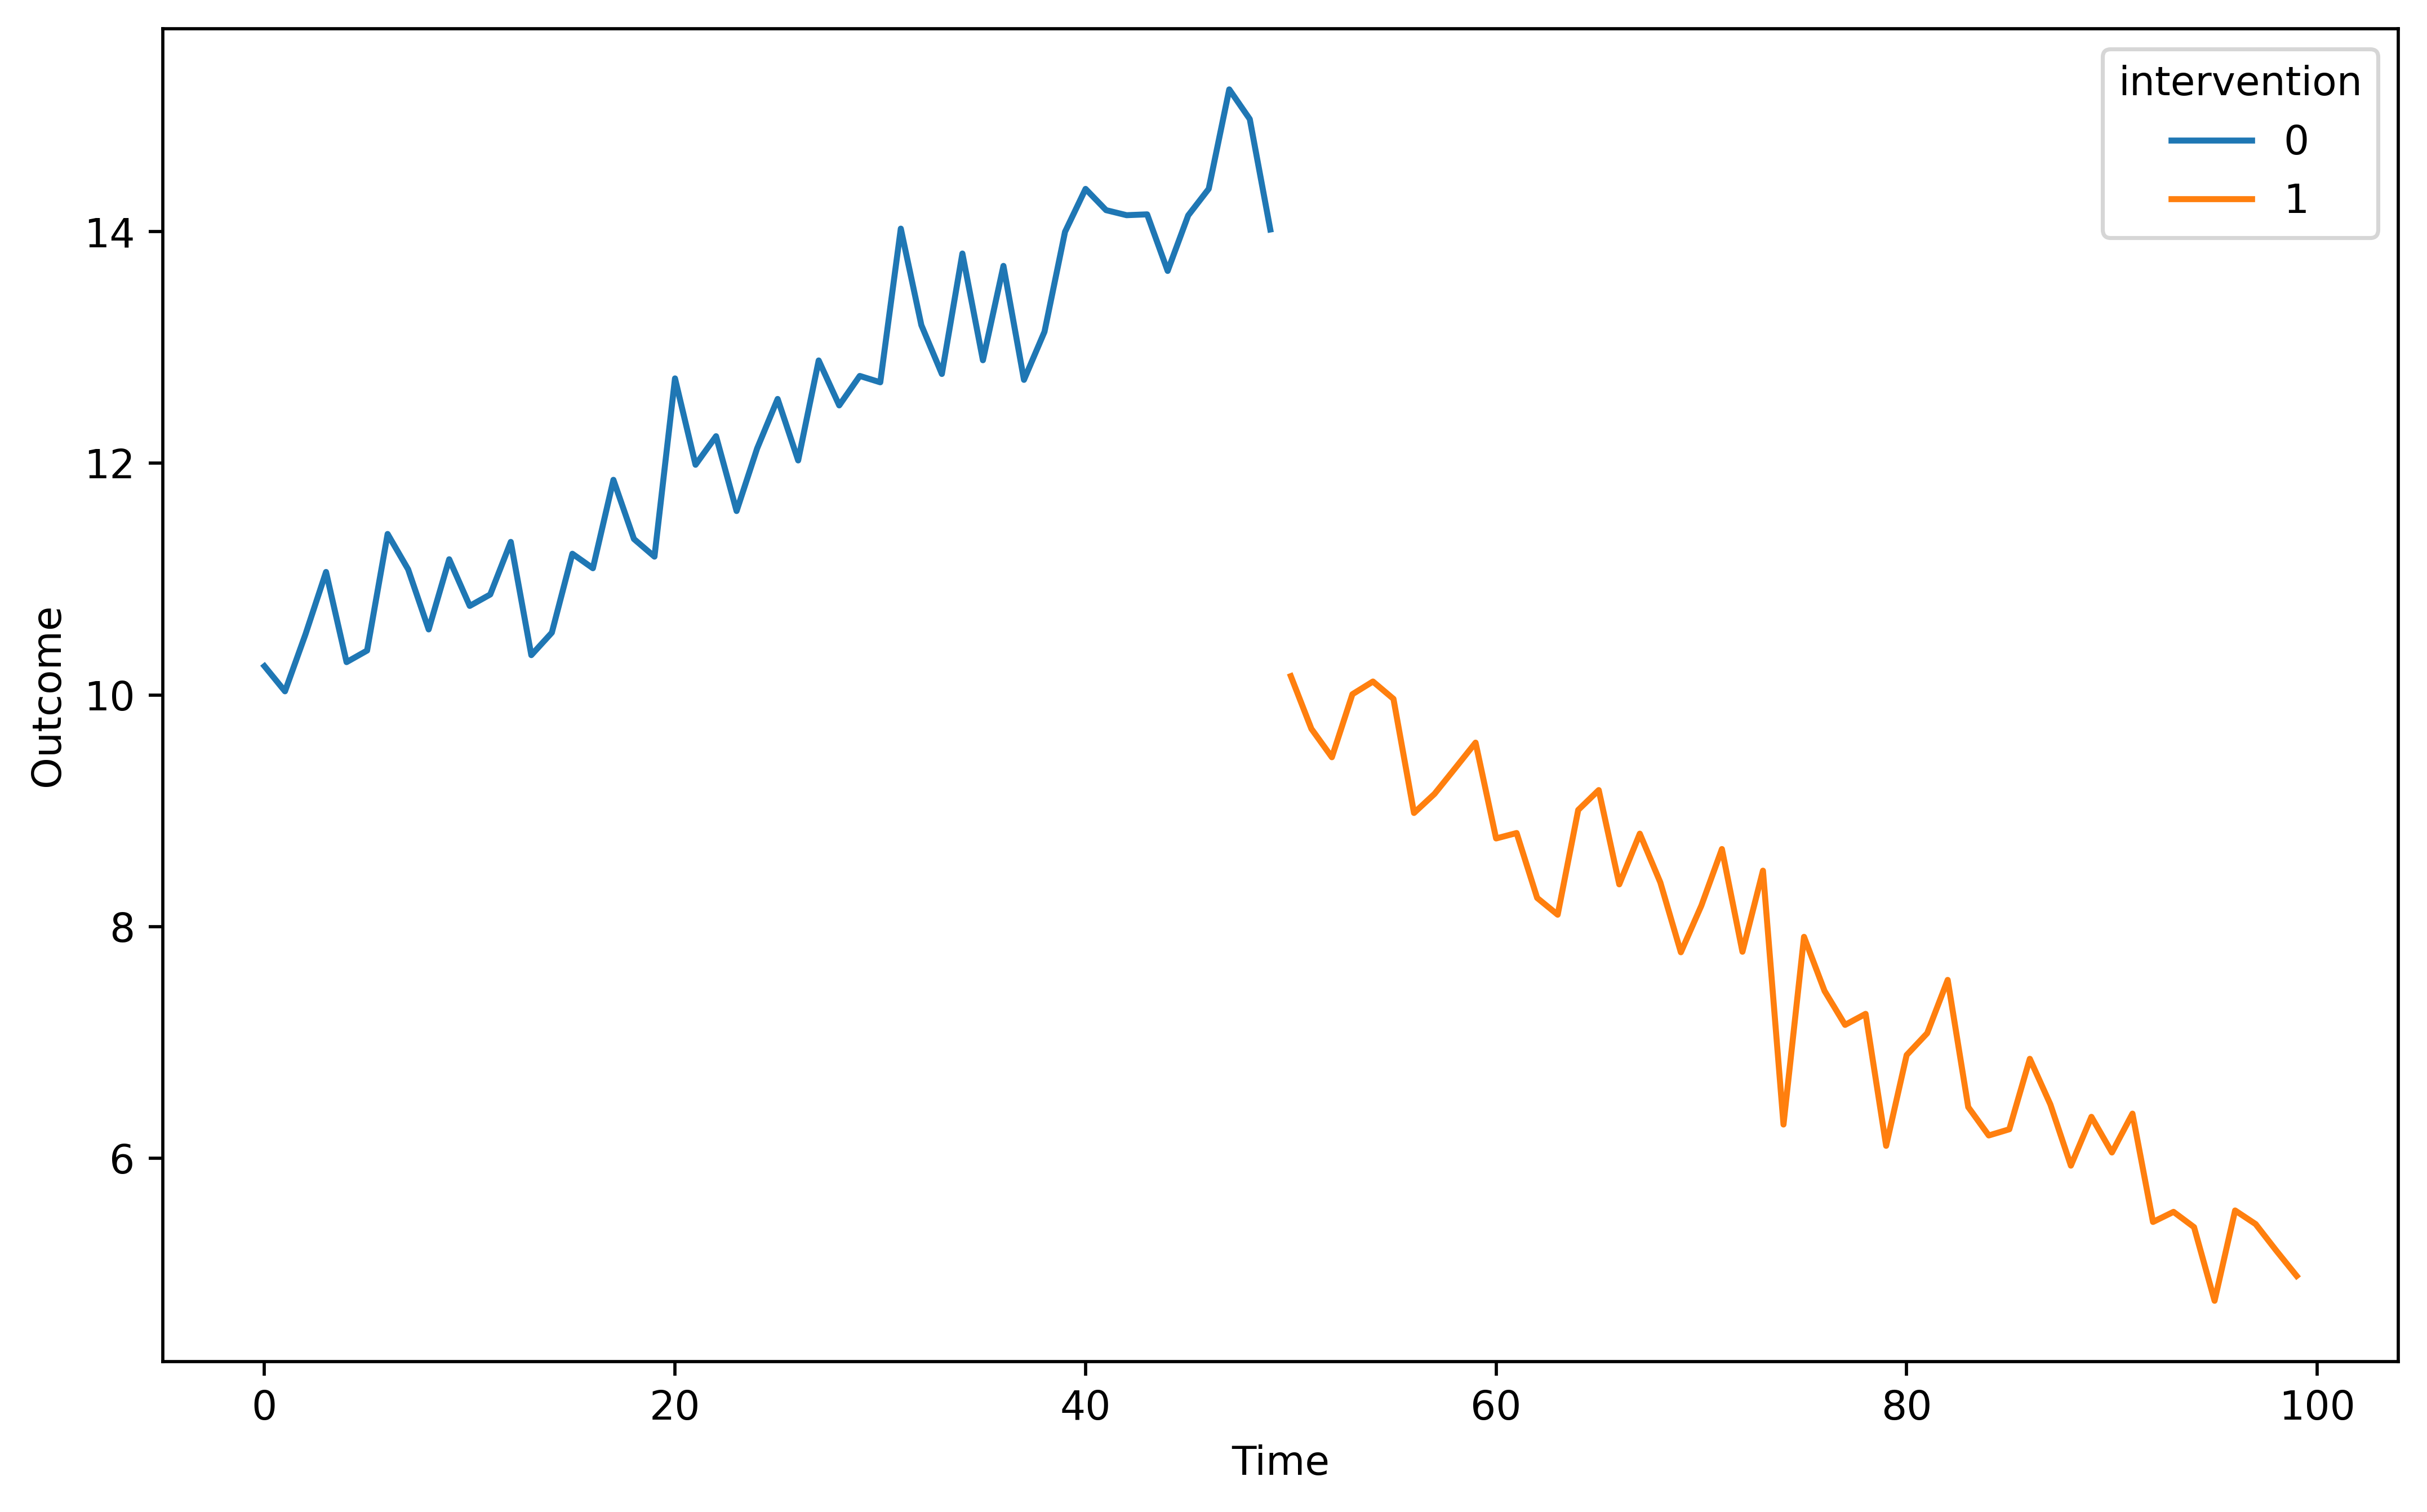

In [67]:
plt.figure(figsize=(10,6),dpi=512)
sns.lineplot(x='time', y='outcome', hue='intervention', data=df)

plt.xlabel('Time')
plt.ylabel('Outcome')

## Apply ITS on data

In [49]:
import statsmodels.api as sm

X = sm.add_constant(df[['time', 'intervention', 'time_after']])
model = sm.OLS(df['outcome'], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1265.
Date:                Mon, 26 May 2025   Prob (F-statistic):           5.29e-77
Time:                        18:56:47   Log-Likelihood:                -60.356
No. Observations:                 100   AIC:                             128.7
Df Residuals:                      96   BIC:                             139.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.0322      0.126     79.723   

A high R-squared value indicates that the model fits the data well.
A small p-value suggests that the results are statistically significant and reliable.
The trend before the intervention was positive, but it turned negative afterward. Assuming the intervention was a hospital policy and the outcome measured the number of ICU patients, this policy effectively altered the system to reduce patient numbers, which is beneficial for resource management.

## Plotting the Results

<ipython-input-69-77ef8ce1c47c>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(np.linspace(0,50,100), model.params[0]+model.params[1] *np.linspace(0,50,100), color = 'black')
<ipython-input-69-77ef8ce1c47c>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(np.linspace(50,100,100), model.params[0]+model.params[1] *np.linspace(50,100,100)+model.params[2]+model.params[3] * (np.linspace(50,100,100)-50), color = 'black')


Text(0, 0.5, 'Outcome')

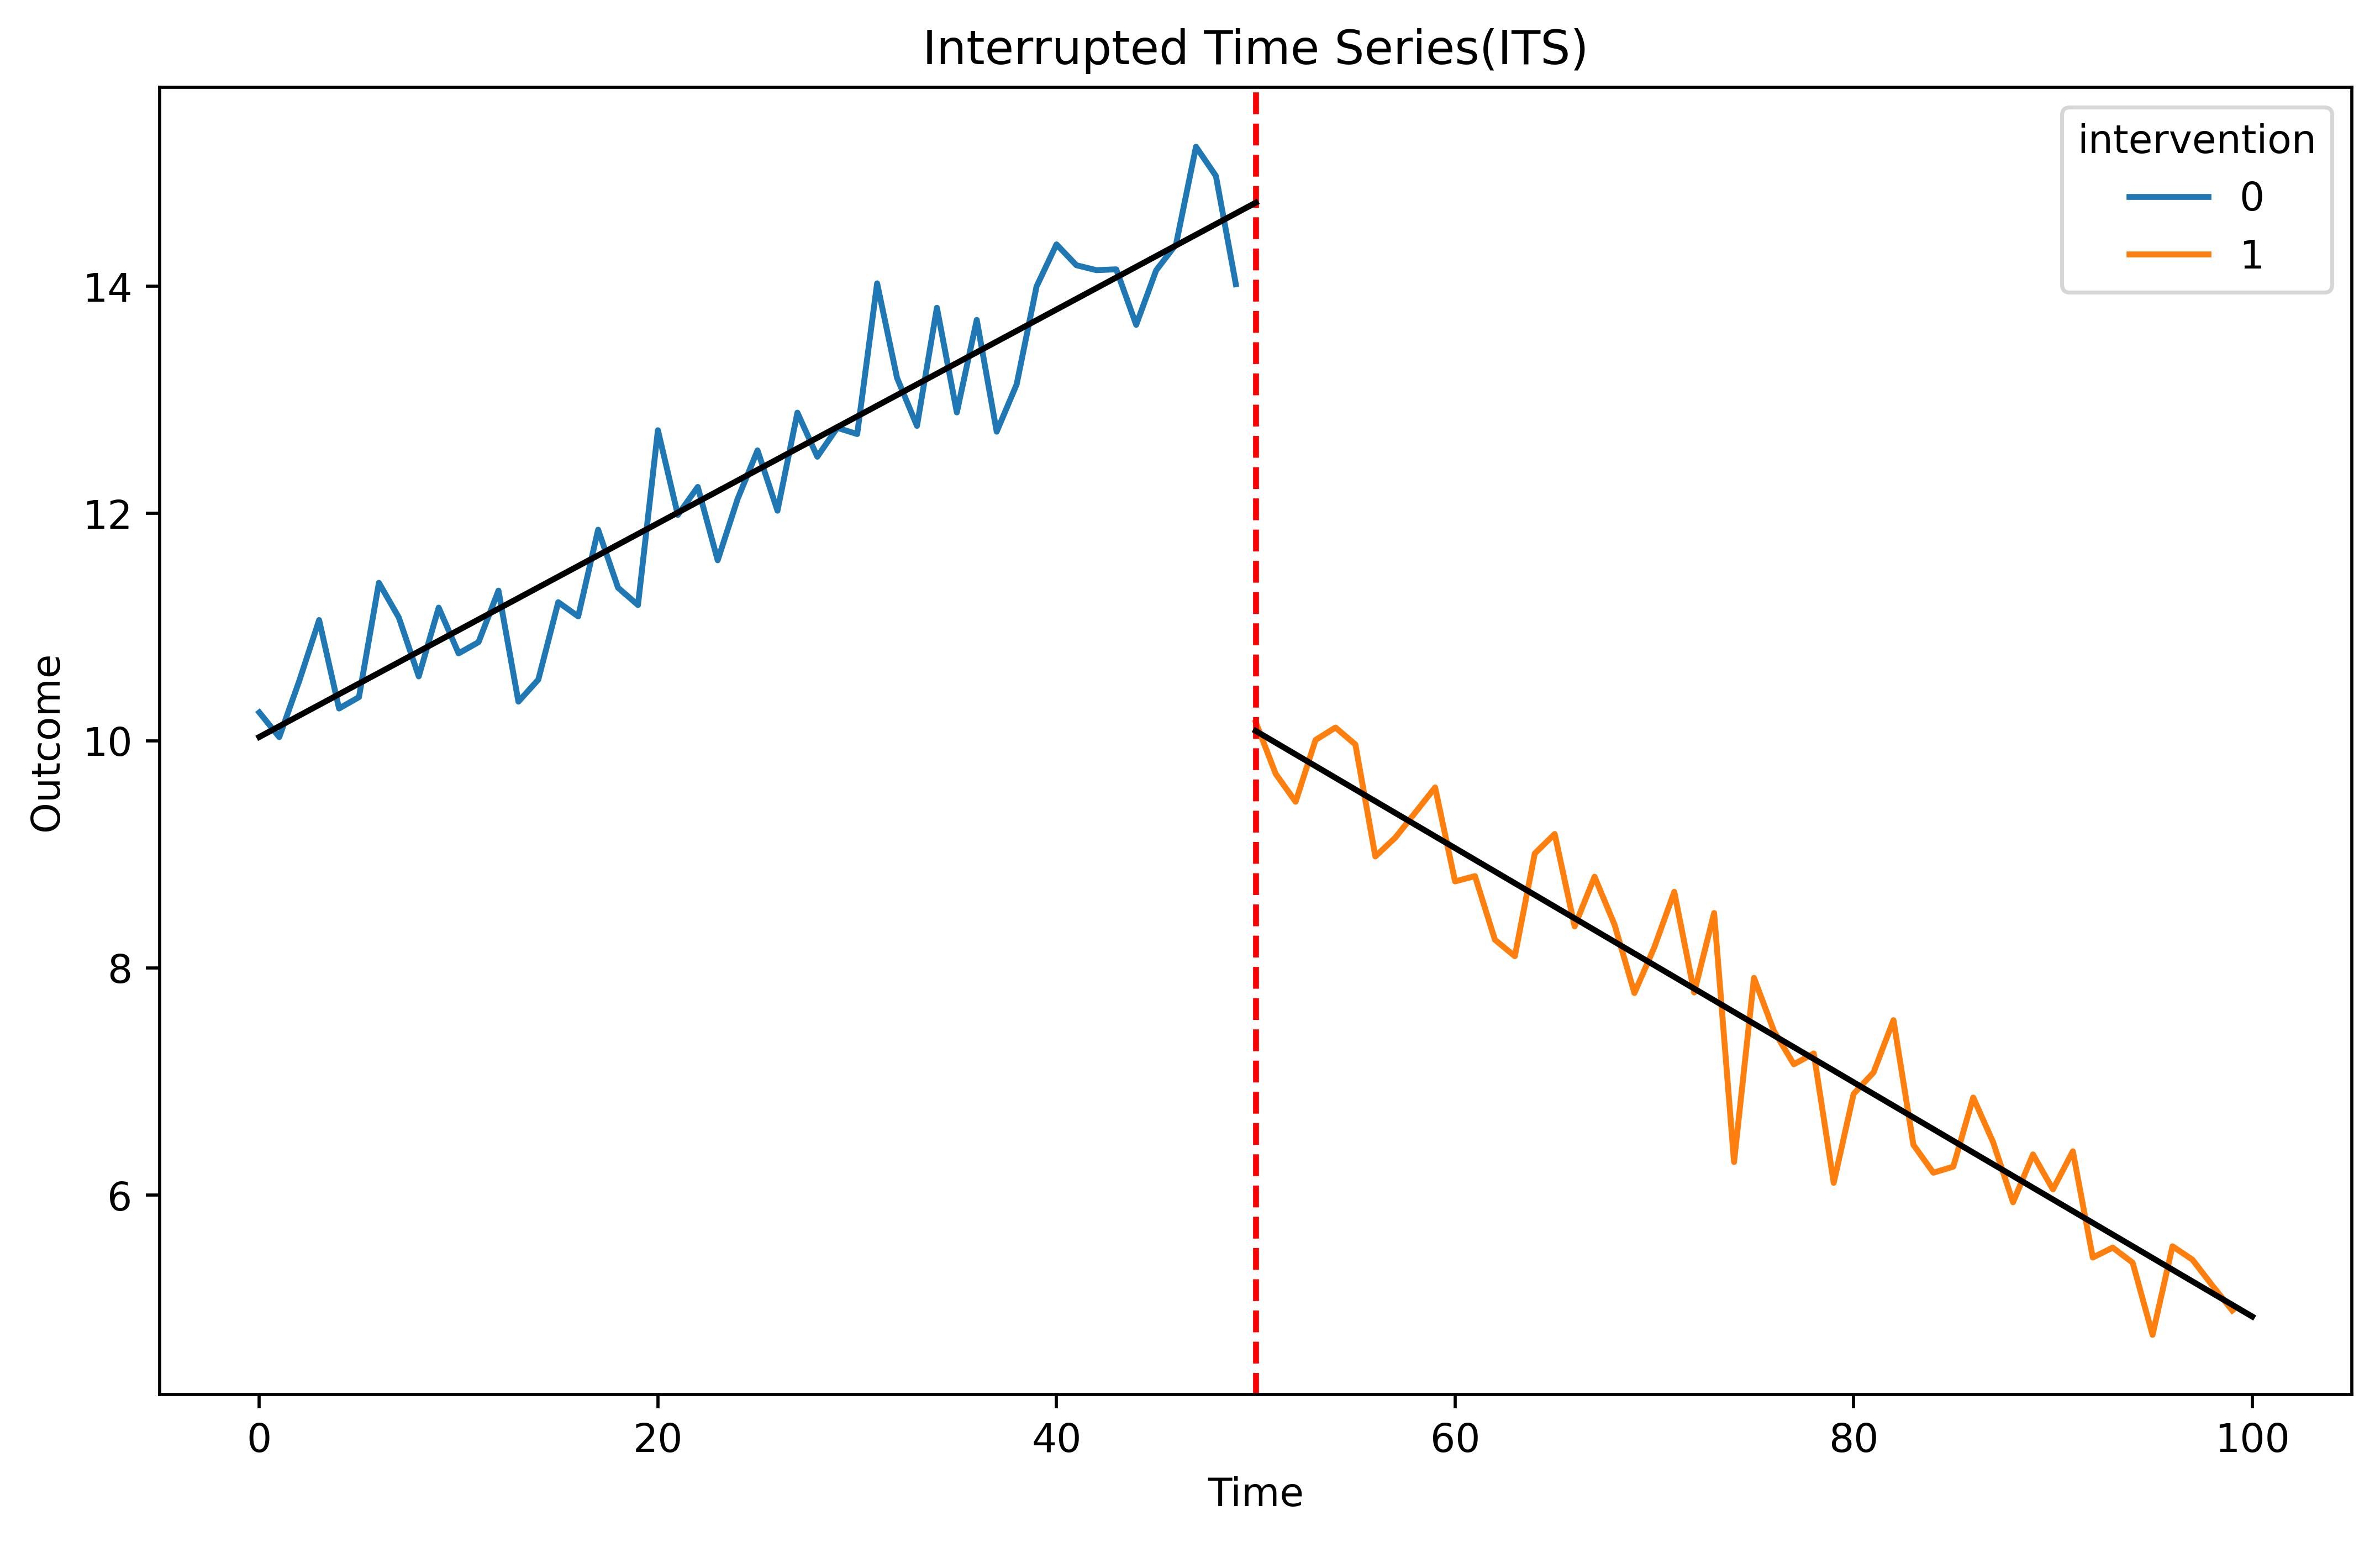

In [69]:
plt.figure(figsize=(10,6),dpi=512)
sns.lineplot(x='time', y='outcome', hue='intervention', data=df)

plt.axvline(x=50, color='r', linestyle='--')


plt.plot(np.linspace(0,50,100), model.params[0]+model.params[1] *np.linspace(0,50,100), color = 'black')
plt.plot(np.linspace(50,100,100), model.params[0]+model.params[1] *np.linspace(50,100,100)+model.params[2]+model.params[3] * (np.linspace(50,100,100)-50), color = 'black')
plt.title("Interrupted Time Series(ITS)")
plt.xlabel('Time')
plt.ylabel('Outcome')

# Regression Discontinuity Design (RDD)



This method is useful when there is a cutoff that determines treatment assignment. In this approach, we focus on cases near the cutoff—those just below it serve as the control group, and those just above it serve as the treatment group. By comparing these groups, we can estimate the treatment’s effectiveness.

## Generate artificial dataset

In [70]:
np.random.seed(42)

n = 200
score = np.random.uniform(40, 60, n)
treatment = (score >= 50).astype(int)  # cutoff
outcome = 0.5 * score + 5 * treatment + np.random.normal(0, 1, n)

df = pd.DataFrame({'score': score, 'treatment': treatment, 'outcome': outcome})
df.head()

,score,treatment,outcome
0,47.490802,0,23.065376
1,59.014286,1,34.739397
2,54.639879,1,32.613012
3,51.973170,1,30.272233
4,43.120373,0,23.425961


Text(0, 0.5, 'Outcome')

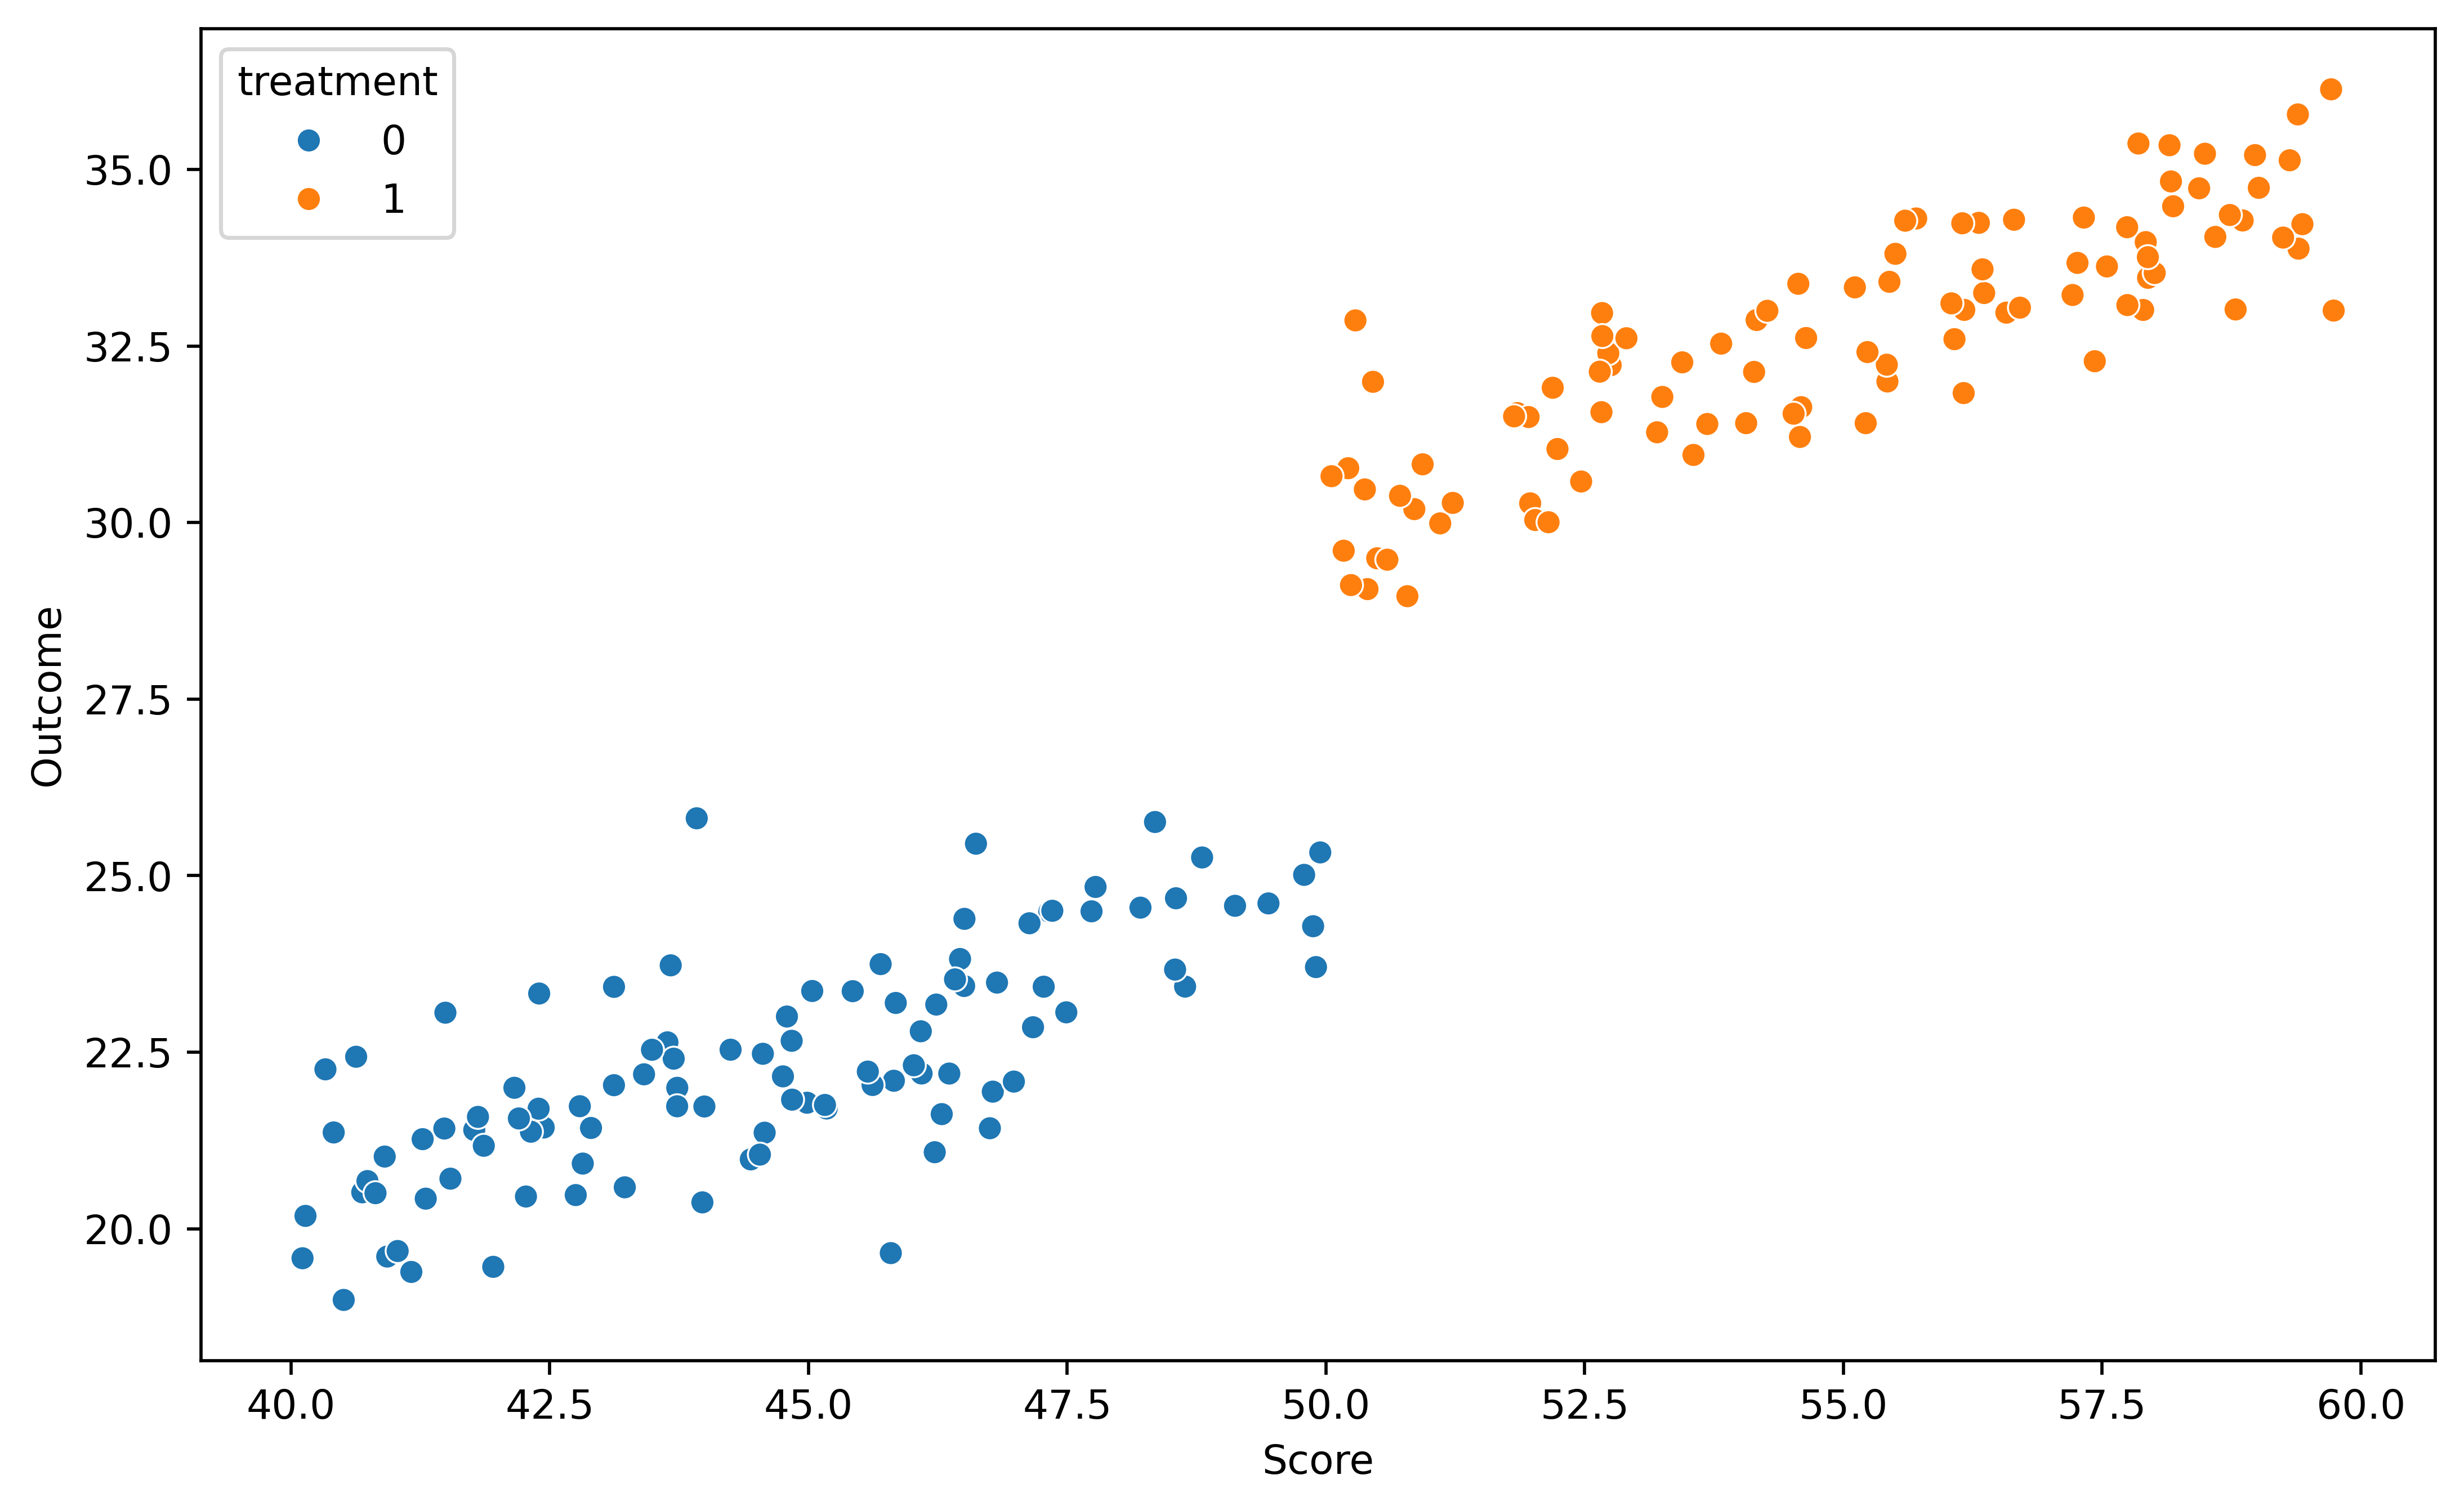

In [71]:
plt.figure(figsize=(10,6),dpi=512)
sns.scatterplot(x='score', y='outcome', hue='treatment', data=df)
plt.xlabel('Score')
plt.ylabel('Outcome')

## Apply RDD on data

In [72]:
from statsmodels.formula.api import ols
model = ols('outcome ~ score + treatment + score:treatment', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1981.
Date:                Mon, 26 May 2025   Prob (F-statistic):          2.76e-146
Time:                        19:09:46   Log-Likelihood:                -275.26
No. Observations:                 200   AIC:                             558.5
Df Residuals:                     196   BIC:                             571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8750      1.606     

The model can explain the date with high R_squared value.

## Plotting the Results

<ipython-input-73-8296beff4e1d>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(np.linspace(40,50,100), model.params[0]+model.params[1] *np.linspace(40,50,100), color = 'black')
<ipython-input-73-8296beff4e1d>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(np.linspace(50,60,100), model.params[0]+model.params[1] *np.linspace(50,60,100)+model.params[2]+model.params[3] * np.linspace(50,60,100), color = 'black')


Text(0, 0.5, 'Outcome')

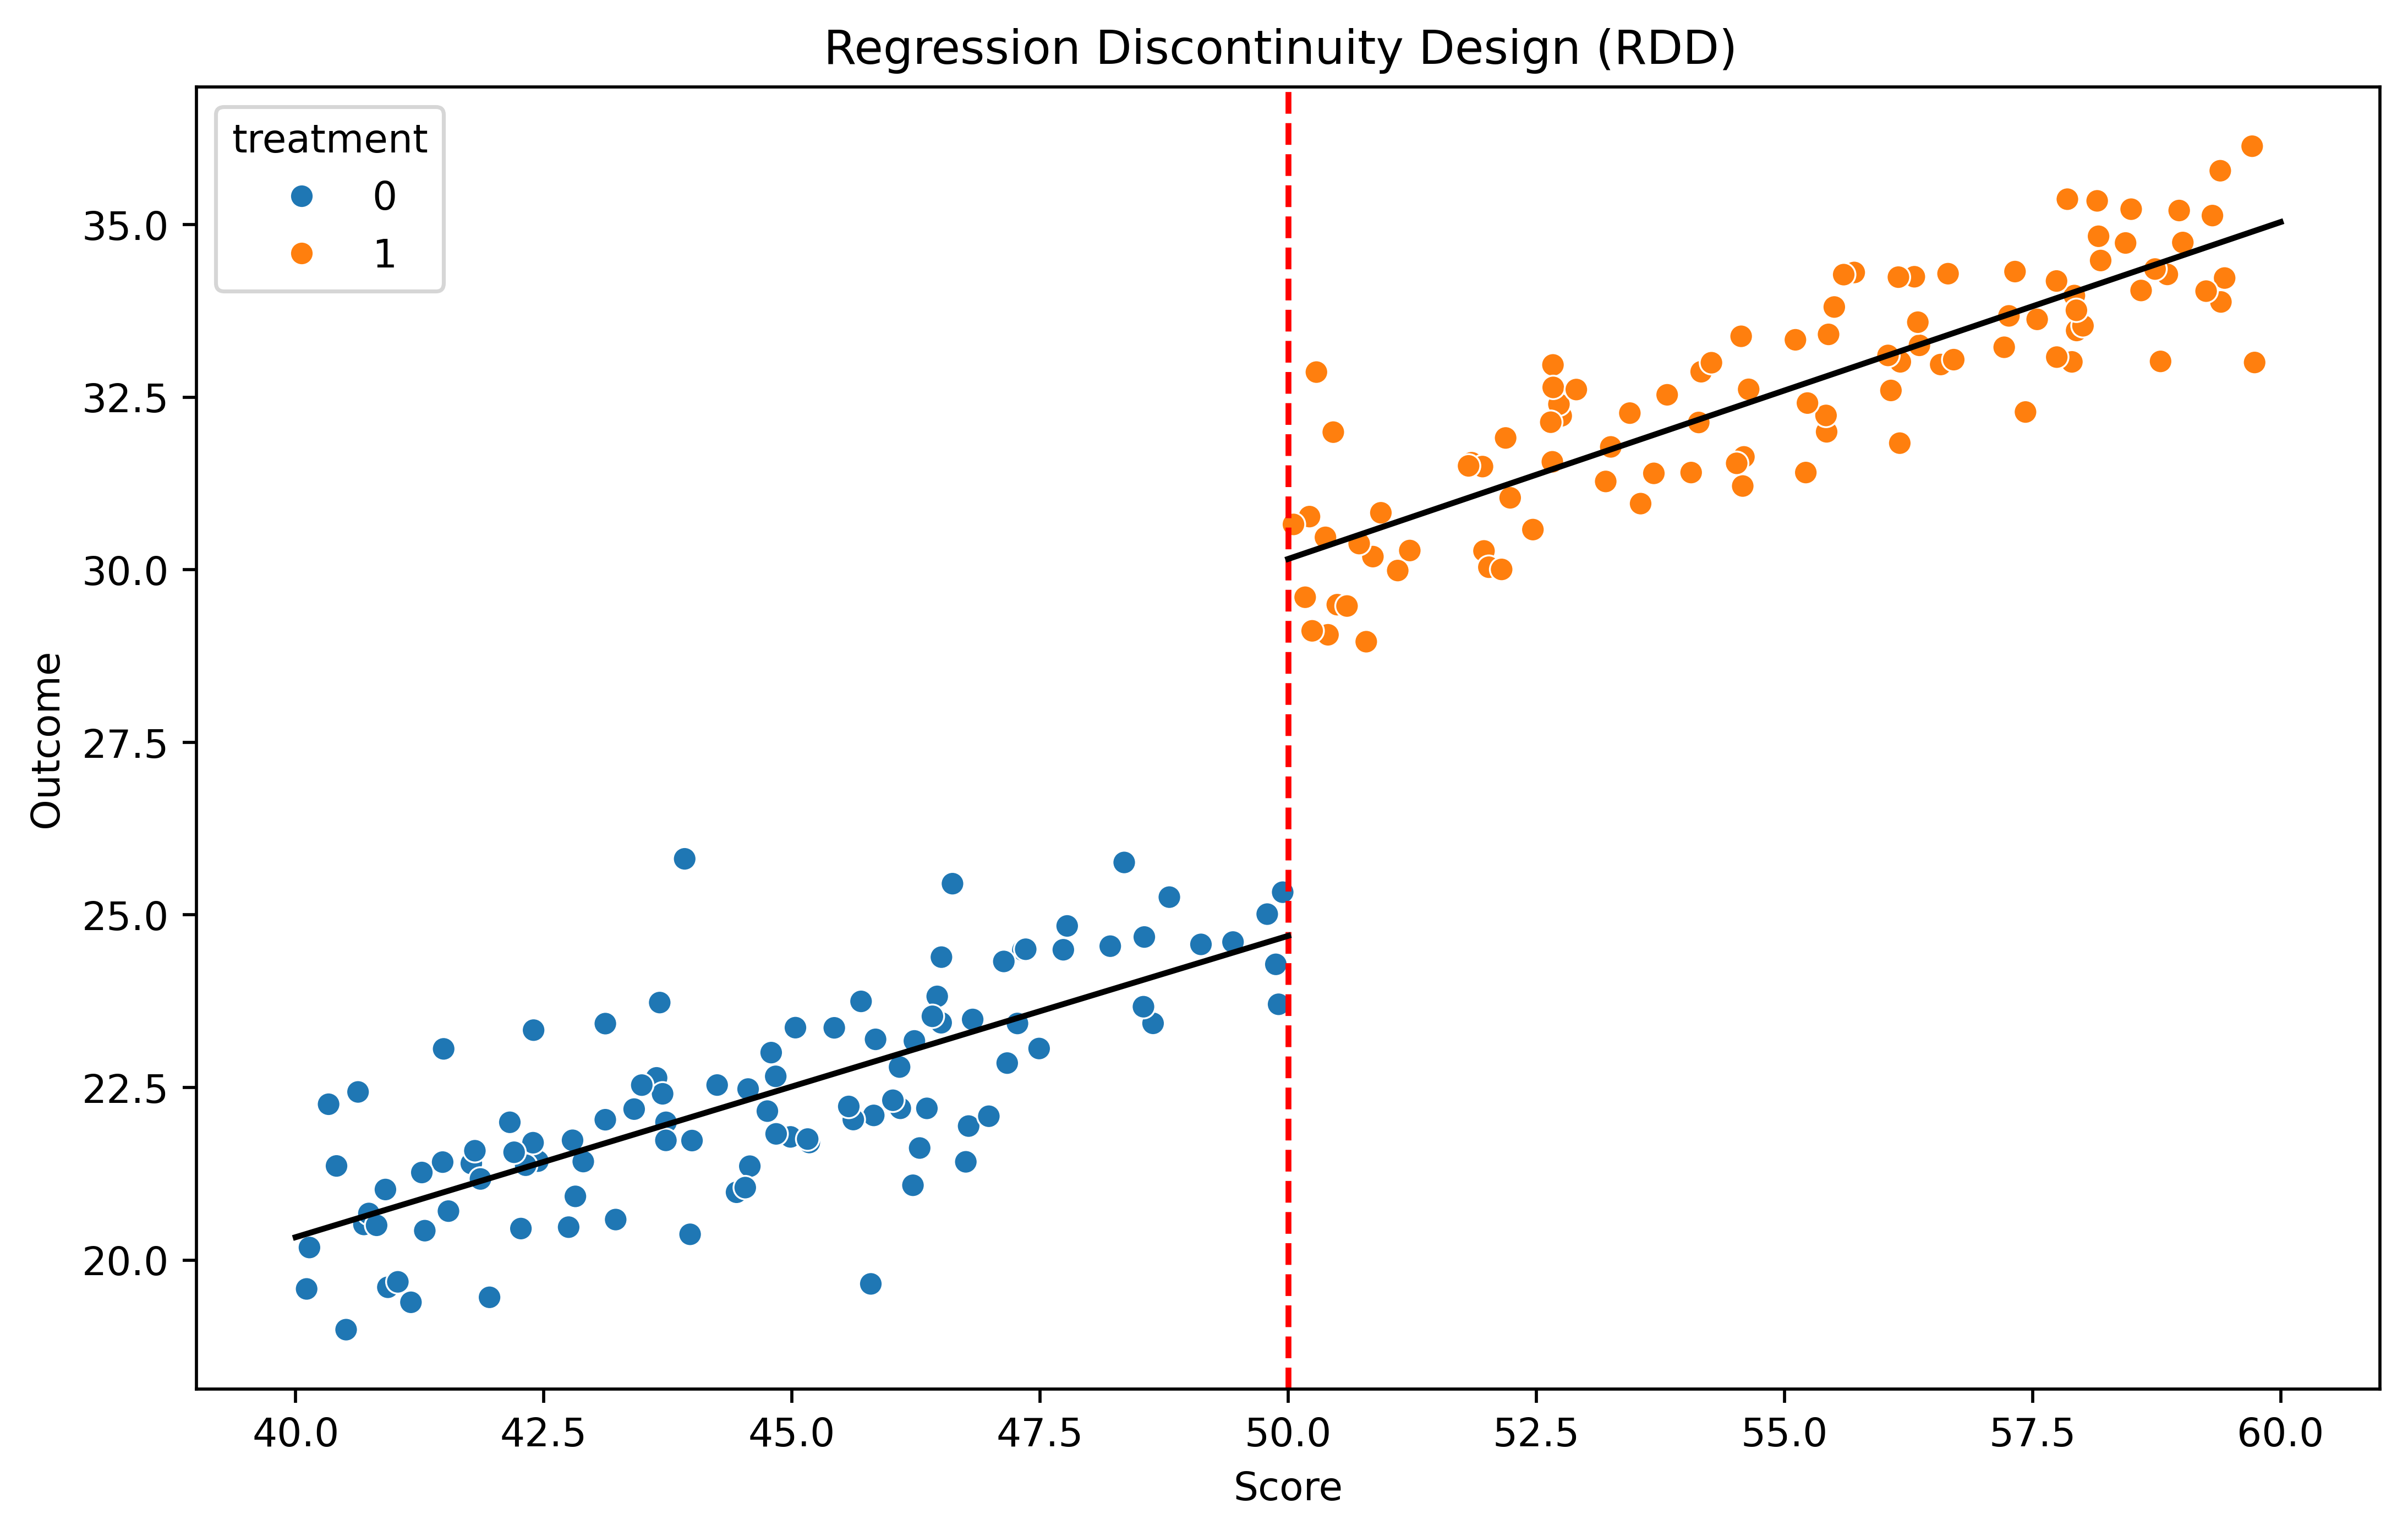

In [73]:
plt.figure(figsize=(10,6),dpi=512)
sns.scatterplot(x='score', y='outcome', hue='treatment', data=df)
plt.axvline(x=50, color='r', linestyle='--')
plt.plot(np.linspace(40,50,100), model.params[0]+model.params[1] *np.linspace(40,50,100), color = 'black')
plt.plot(np.linspace(50,60,100), model.params[0]+model.params[1] *np.linspace(50,60,100)+model.params[2]+model.params[3] * np.linspace(50,60,100), color = 'black')
plt.title("Regression Discontinuity Design (RDD) ")
plt.xlabel('Score')
plt.ylabel('Outcome')

# Instrumental Variables (IV)
This method is used to estimate the causal effect of a treatment when a confounding variable is present.

For example, suppose we want to measure the effect of a specific medication on blood pressure. However, patients with more severe blood pressure issues are more likely to take higher doses of the medication. This makes it difficult to isolate the treatment effect, as the severity itself influences both the treatment and the outcome.

To address this, we introduce an instrumental variable—a factor that affects the treatment but is not directly related to the outcome. For instance, we might use doctors who tend to prescribe more of the medication as the instrument.

First, we model how the treatment relates to the instrument:
$treatment ≈ a + b × instrument$

Next, we use the predicted treatment values from this model to estimate the outcome:
$outcome ≈ c + d × (predicted treatment)$

Here, the coefficient  𝑑 captures the effect of the treatment, adjusted for confounding variables using the instrument.

## Generate an artificial dataset

In [127]:
np.random.seed(42)
n = 200
df = pd.DataFrame({
    'doctor': np.random.randint(0, 2, size=n),
    'baseline_bp': np.random.normal(120, 10, size=n)
})

# treatment is partially determined by doctor (the instrument)
df['treatment'] = (df['doctor'] * 0.8 + np.random.normal(0, 0.2, size=n)).astype(int)
# outcome depends on treatment + baseline_bp
df['outcome'] = 5 * df['treatment'] + 0.1 * df['baseline_bp'] + np.random.normal(0, 1, size=n)
df.head()

,doctor,baseline_bp,treatment,outcome
0,0,120.870471,0,12.663604
1,1,117.009926,0,12.012243
2,0,120.917608,0,15.170642
3,0,100.124311,0,11.132006
4,0,117.803281,0,11.652411


## Apply IV on data

In [128]:
# IV regression: outcome ~ treatment (instrumented by doctor)

y = df['outcome']
X = sm.add_constant(df[['baseline_bp']])  # exogenous regressors
endog = df['treatment']
instrument = df['doctor']

iv_model = IV2SLS(y, X, endog, instrument).fit()
print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                outcome   R-squared:                      0.5965
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5924
No. Observations:                 200   F-statistic:                    147.05
Date:                Mon, May 26 2025   P-value (F-stat)                0.0000
Time:                        20:05:28   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           1.2443     0.9200     1.3525     0.1762     -0.5589      3.0475
baseline_bp     0.0902     0.0077     11.728    